# 08. Phase 6: 勝敗予測モデル - 視界スコア比較評価

## 概要
- LoL勝敗予測モデルを構築
- Riot公式visionScoreと自作視界スコア（ward座標グリッドベース）の予測精度への貢献度を比較
- 評価時点: 10分、20分

## 比較モデル
1. **baseline**: 標準特徴量（gold, kills, dragons等）のみ
2. **baseline_riot**: ベースライン + Riot visionScore推定値
3. **baseline_grid**: ベースライン + 自作視界スコア（wardグリッド特徴量）

In [1]:
# Cell 1: インポートとパス設定
import sys
from pathlib import Path

# プロジェクトルートをパスに追加
PROJECT_ROOT = Path(r"c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2")
sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import pandas as pd

# Phase 6モジュール
from autoLeague.prediction.feature_extractor import (
    build_prediction_dataset,
    load_prediction_dataset,
)
from autoLeague.prediction.baseline_predictor import (
    WinPredictor,
    prepare_features,
    train_all_models,
)
from autoLeague.prediction.evaluator import (
    compare_models,
    summarize_contributions,
    generate_report,
    visualize_comparison,
    visualize_feature_importance,
)

print("インポート完了")

インポート完了


In [2]:
# Cell 2: パス定義

# データディレクトリ
DATA_DIR = PROJECT_ROOT / "data"
TIMELINE_DIR = DATA_DIR / "timeline"
MATCH_DIR = DATA_DIR / "match"
DATASET_DIR = Path(r"C:\dataset_20260105")  # wards_matched.csv格納先

# 出力先
OUTPUT_DIR = DATA_DIR
MODEL_DIR = PROJECT_ROOT / "models"
RESULTS_DIR = PROJECT_ROOT / "results"

# データセットファイル
DATASET_PATH = OUTPUT_DIR / "prediction_dataset.npz"

print(f"Timeline DIR: {TIMELINE_DIR}")
print(f"Match DIR: {MATCH_DIR}")
print(f"Dataset DIR: {DATASET_DIR}")
print(f"Output: {DATASET_PATH}")

Timeline DIR: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\data\timeline
Match DIR: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\data\match
Dataset DIR: C:\dataset_20260105
Output: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\data\prediction_dataset.npz


---
## 1. データセット構築

In [3]:
# Cell 3: データセット構築
# 初回のみ実行。すでにデータセットがある場合はスキップ可能

if not DATASET_PATH.exists():
    print("データセットを構築中...")
    stats = build_prediction_dataset(
        timeline_dir=TIMELINE_DIR,
        match_dir=MATCH_DIR,
        dataset_dir=DATASET_DIR,
        output_path=DATASET_PATH,
        verbose=True,
    )
    print(f"\n構築完了: {stats}")
else:
    print(f"既存のデータセットを使用: {DATASET_PATH}")

既存のデータセットを使用: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\data\prediction_dataset.npz


In [4]:
# Cell 4: データセット読み込み

dataset = load_prediction_dataset(DATASET_PATH)

print(f"試合数: {len(dataset['match_ids'])}")
print(f"評価時点: {[t // 60000 for t in dataset['times_ms']]} 分")
print(f"ベースライン特徴量: {len(dataset['baseline_features'])}個")
print(f"Riot visionScore特徴量: {len(dataset['riot_vision_features'])}個")
print(f"\nX_baseline shape: {dataset['X_baseline'].shape}")
print(f"X_riot_vision shape: {dataset['X_riot_vision'].shape}")
print(f"X_ward_grid shape: {dataset['X_ward_grid'].shape}")
print(f"y shape: {dataset['y'].shape}")
print(f"\nBlue勝利: {dataset['y'].sum()}, Red勝利: {len(dataset['y']) - dataset['y'].sum()}")

試合数: 13
評価時点: [10, 20] 分
ベースライン特徴量: 20個
Riot visionScore特徴量: 3個

X_baseline shape: (13, 2, 20)
X_riot_vision shape: (13, 2, 3)
X_ward_grid shape: (13, 2, 2, 32, 32)
y shape: (13,)

Blue勝利: 9, Red勝利: 4


In [5]:
# Cell 5: 特徴量一覧

print("=== ベースライン特徴量 ===")
for i, f in enumerate(dataset['baseline_features']):
    print(f"  {i+1}. {f}")

print("\n=== Riot visionScore特徴量 ===")
for i, f in enumerate(dataset['riot_vision_features']):
    print(f"  {i+1}. {f}")

=== ベースライン特徴量 ===
  1. blue_total_gold
  2. red_total_gold
  3. gold_diff
  4. blue_total_xp
  5. red_total_xp
  6. blue_avg_level
  7. red_avg_level
  8. blue_total_cs
  9. red_total_cs
  10. blue_kills
  11. red_kills
  12. kill_diff
  13. blue_dragons
  14. red_dragons
  15. blue_heralds
  16. red_heralds
  17. blue_towers
  18. red_towers
  19. blue_wards_placed
  20. red_wards_placed

=== Riot visionScore特徴量 ===
  1. blue_vision_score_est
  2. red_vision_score_est
  3. vision_score_diff


---
## 2. モデル学習・評価（10分時点）

In [6]:
# Cell 6: 10分時点のモデル学習

print("=" * 50)
print("10分時点のモデル学習 (Leave-One-Out CV)")
print("=" * 50)

results_10min = train_all_models(
    dataset=dataset,
    time_index=0,  # 10分
    output_dir=MODEL_DIR,
    vision_predictor=None,  # Phase 5のVisionPredictorがあれば指定
    verbose=True,
)

10分時点のモデル学習 (Leave-One-Out CV)
[baseline] LOO-CV Accuracy: 0.769, AUC: 0.722, LogLoss: 0.593
モデル保存: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\models\baseline_10min.joblib
[baseline_riot] LOO-CV Accuracy: 0.769, AUC: 0.694, LogLoss: 0.618
モデル保存: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\models\baseline_riot_10min.joblib
[baseline_grid] LOO-CV Accuracy: 0.692, AUC: 0.611, LogLoss: 0.640
モデル保存: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\models\baseline_grid_10min.joblib


In [7]:
# Cell 7: 10分時点の結果比較

print("\n=== 10分時点 モデル比較 ===")
df_10 = compare_models(results_10min)
print(df_10.to_string(index=False))


=== 10分時点 モデル比較 ===
        Model  CV Accuracy   CV AUC  CV LogLoss  N Features
     baseline     0.769231 0.722222    0.593054          20
baseline_riot     0.769231 0.694444    0.618099          23
baseline_grid     0.692308 0.611111    0.640083          26


In [8]:
# Cell 8: 10分時点の貢献度

print("\n=== 10分時点 視界スコア貢献度 ===")
contributions_10 = summarize_contributions(results_10min)

for model_name, contrib in contributions_10.items():
    print(f"\n{model_name}:")
    print(f"  ベースライン精度: {contrib['baseline_score']:.3f}")
    print(f"  拡張モデル精度: {contrib['extended_score']:.3f}")
    print(f"  精度向上: {contrib['absolute_lift_pct']:.2f}%")
    print(f"  相対貢献度: {contrib['relative_contribution_pct']:.2f}%")


=== 10分時点 視界スコア貢献度 ===

baseline_riot:
  ベースライン精度: 0.769
  拡張モデル精度: 0.769
  精度向上: 0.00%
  相対貢献度: 0.00%

baseline_grid:
  ベースライン精度: 0.769
  拡張モデル精度: 0.692
  精度向上: -7.69%
  相対貢献度: -33.33%


---
## 3. モデル学習・評価（20分時点）

In [9]:
# Cell 9: 20分時点のモデル学習

print("=" * 50)
print("20分時点のモデル学習 (Leave-One-Out CV)")
print("=" * 50)

results_20min = train_all_models(
    dataset=dataset,
    time_index=1,  # 20分
    output_dir=MODEL_DIR,
    vision_predictor=None,
    verbose=True,
)

20分時点のモデル学習 (Leave-One-Out CV)
[baseline] LOO-CV Accuracy: 0.846, AUC: 0.944, LogLoss: 0.386
モデル保存: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\models\baseline_20min.joblib
[baseline_riot] LOO-CV Accuracy: 0.846, AUC: 0.944, LogLoss: 0.388
モデル保存: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\models\baseline_riot_20min.joblib
[baseline_grid] LOO-CV Accuracy: 0.769, AUC: 0.917, LogLoss: 0.421
モデル保存: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\models\baseline_grid_20min.joblib


In [10]:
# Cell 10: 20分時点の結果比較

print("\n=== 20分時点 モデル比較 ===")
df_20 = compare_models(results_20min)
print(df_20.to_string(index=False))


=== 20分時点 モデル比較 ===
        Model  CV Accuracy   CV AUC  CV LogLoss  N Features
     baseline     0.846154 0.944444    0.386272          20
baseline_riot     0.846154 0.944444    0.387521          23
baseline_grid     0.769231 0.916667    0.420633          26


In [11]:
# Cell 11: 20分時点の貢献度

print("\n=== 20分時点 視界スコア貢献度 ===")
contributions_20 = summarize_contributions(results_20min)

for model_name, contrib in contributions_20.items():
    print(f"\n{model_name}:")
    print(f"  ベースライン精度: {contrib['baseline_score']:.3f}")
    print(f"  拡張モデル精度: {contrib['extended_score']:.3f}")
    print(f"  精度向上: {contrib['absolute_lift_pct']:.2f}%")
    print(f"  相対貢献度: {contrib['relative_contribution_pct']:.2f}%")


=== 20分時点 視界スコア貢献度 ===

baseline_riot:
  ベースライン精度: 0.846
  拡張モデル精度: 0.846
  精度向上: 0.00%
  相対貢献度: 0.00%

baseline_grid:
  ベースライン精度: 0.846
  拡張モデル精度: 0.769
  精度向上: -7.69%
  相対貢献度: -50.00%


---
## 4. 総合レポート

In [12]:
# Cell 12: 総合レポート生成

RESULTS_DIR.mkdir(parents=True, exist_ok=True)

report = generate_report(
    results_10min=results_10min,
    results_20min=results_20min,
    output_path=RESULTS_DIR / "model_comparison.json",
)

print(report)

JSON保存: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\results\model_comparison.json
Phase 6: 勝敗予測モデル比較レポート

## 10分時点
----------------------------------------
        Model  CV Accuracy   CV AUC  CV LogLoss  N Features
     baseline     0.769231 0.722222    0.593054          20
baseline_riot     0.769231 0.694444    0.618099          23
baseline_grid     0.692308 0.611111    0.640083          26

### 視界スコア貢献度 (10分)
  baseline_riot:
    精度向上: 0.00%
    相対貢献度: 0.00%
  baseline_grid:
    精度向上: -7.69%
    相対貢献度: -33.33%

## 20分時点
----------------------------------------
        Model  CV Accuracy   CV AUC  CV LogLoss  N Features
     baseline     0.846154 0.944444    0.386272          20
baseline_riot     0.846154 0.944444    0.387521          23
baseline_grid     0.769231 0.916667    0.420633          26

### 視界スコア貢献度 (20分)
  baseline_riot:
    精度向上: 0.00%
    相対貢献度: 0.00%
  baseline_grid:
    精度向上: -7.69%
    相対貢献度: -50.00%

## 結論
----------------------------------------
最高

---
## 5. 可視化

画像保存: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\results\model_comparison.png


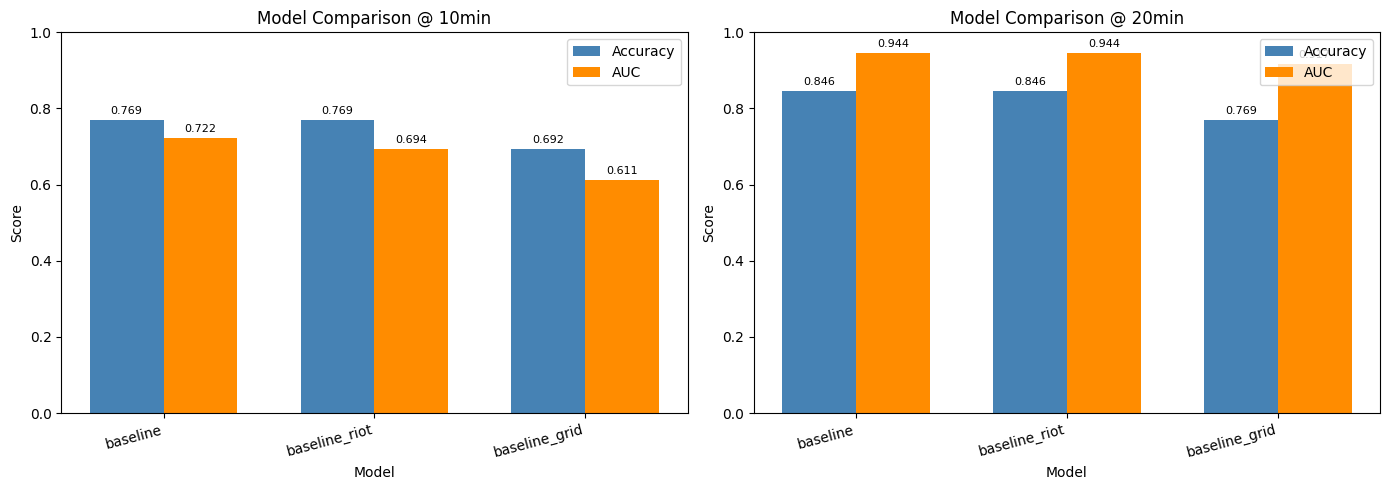

In [13]:
# Cell 13: モデル比較可視化

visualize_comparison(
    results_10min=results_10min,
    results_20min=results_20min,
    output_dir=RESULTS_DIR,
)

画像保存: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\results\feature_importance_10min.png


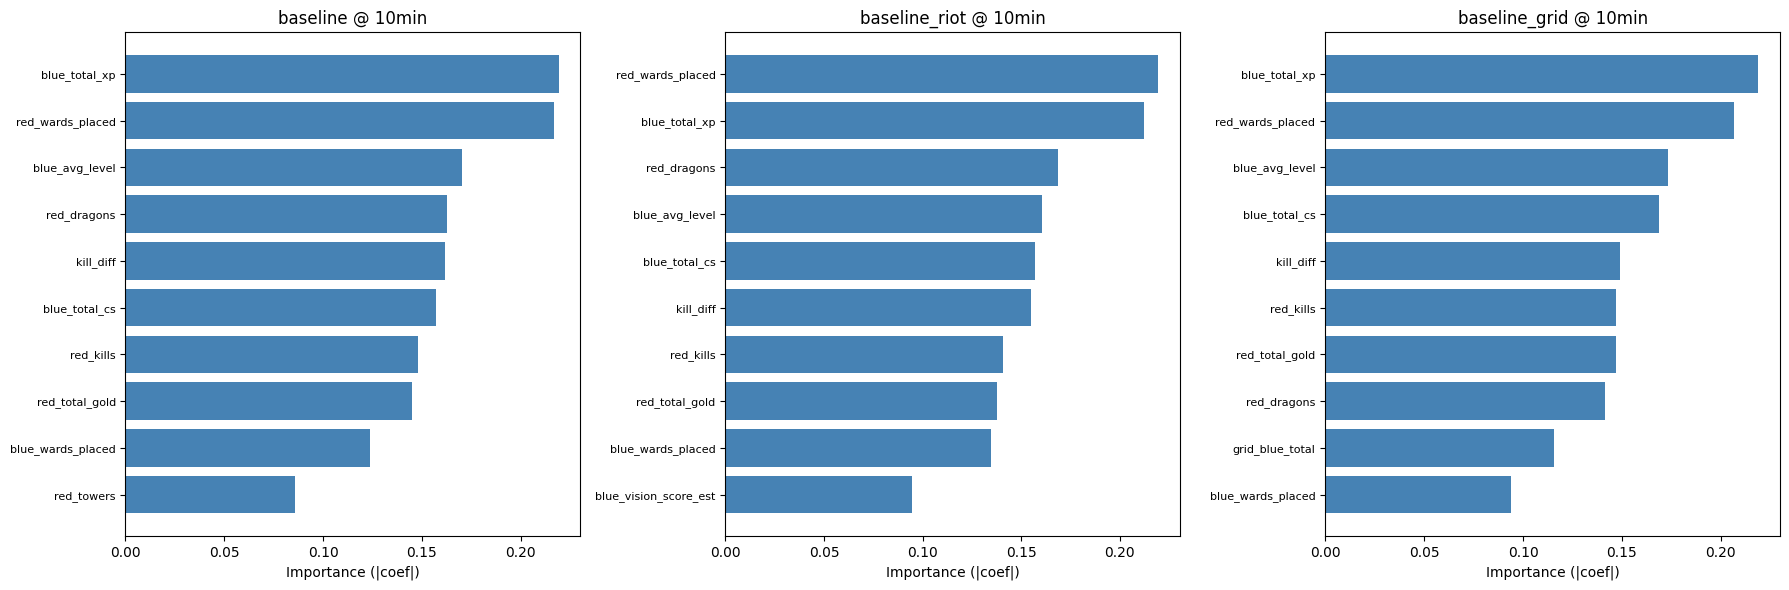

In [14]:
# Cell 14: 特徴量重要度可視化（10分）

visualize_feature_importance(
    results=results_10min,
    time_name="10min",
    output_dir=RESULTS_DIR,
)

画像保存: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\results\feature_importance_20min.png


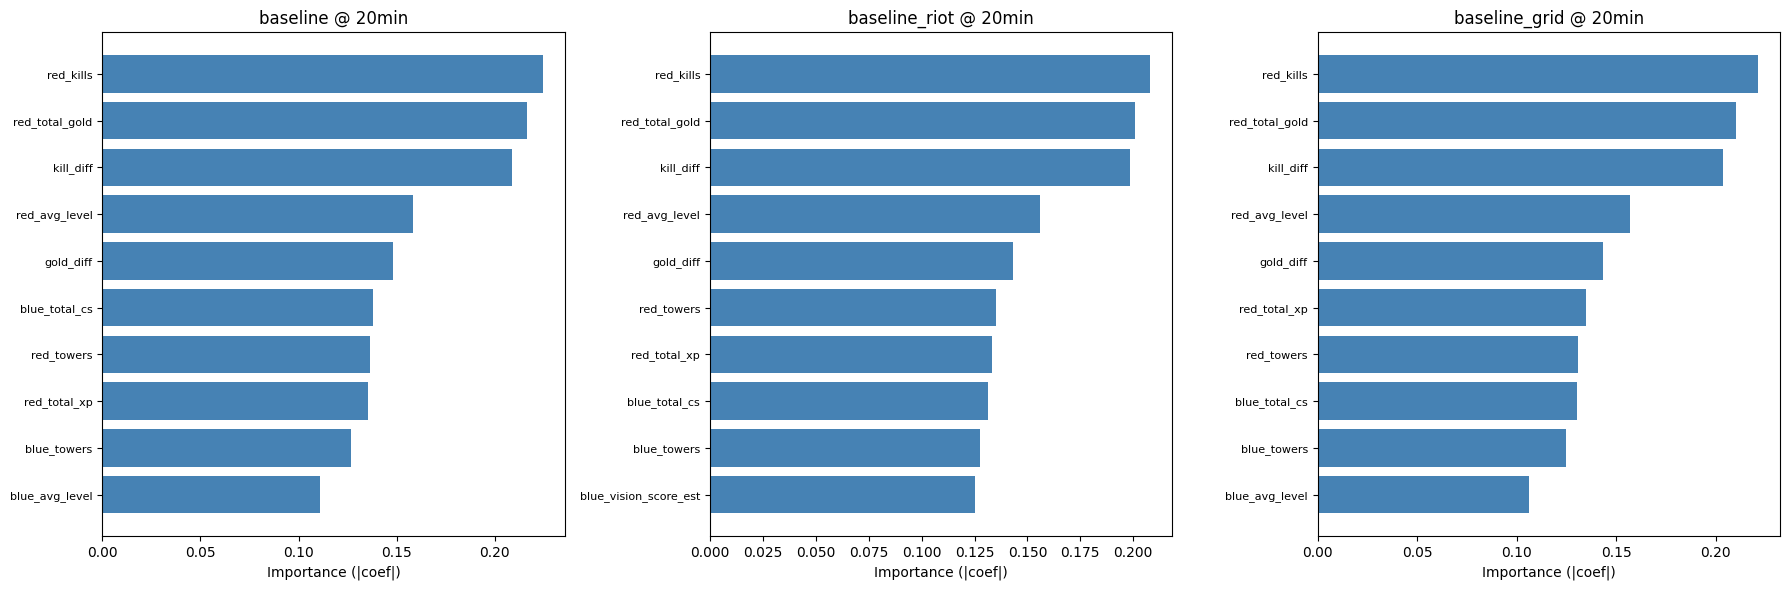

In [15]:
# Cell 15: 特徴量重要度可視化（20分）

visualize_feature_importance(
    results=results_20min,
    time_name="20min",
    output_dir=RESULTS_DIR,
)

---
## 6. 考察

### 結果の解釈

1. **ベースラインモデルの性能**
   - 10分時点: XXX%
   - 20分時点: XXX%
   - 先行研究（10分時点74.4%）との比較

2. **Riot visionScoreの貢献**
   - 精度向上量
   - 考えられる理由

3. **自作視界スコアの貢献**
   - 精度向上量
   - Riot visionScoreとの比較

4. **時間帯による違い**
   - 10分 vs 20分での傾向

### 制約事項
- サンプル数が少ない（26試合）ため、結果の一般化には注意が必要
- Riot visionScoreは途中時点の推定値（実際の値ではない）

### 今後の改善案
- より多くの試合データでの検証
- LightGBMなど他のモデルの検討
- Phase 5のVisionPredictorとの連携

In [16]:
# Cell 16: 結果サマリー表示

print("=" * 60)
print("Phase 6 実験完了")
print("=" * 60)
print(f"\n出力ファイル:")
print(f"  - データセット: {DATASET_PATH}")
print(f"  - モデル: {MODEL_DIR}")
print(f"  - 結果JSON: {RESULTS_DIR / 'model_comparison.json'}")
print(f"  - 比較グラフ: {RESULTS_DIR / 'model_comparison.png'}")

Phase 6 実験完了

出力ファイル:
  - データセット: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\data\prediction_dataset.npz
  - モデル: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\models
  - 結果JSON: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\results\model_comparison.json
  - 比較グラフ: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\results\model_comparison.png
